In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
%matplotlib inline

In [2]:
path.insert(0, '../src')
from data_generator import DataGenerator
from model_trainer import ModelTrainer

In [3]:
from data_transformation import get_better_spectra, get_precise_peaks
dg = DataGenerator('../data/classification_cas_data.csv')
norm_data = dg.df()

In [4]:
data = get_better_spectra()
norm_data.sort_values('file_name', inplace=True)
data.sort_values('file_name', inplace=True)
norm_data = pd.merge(data, norm_data, on='file_name')

In [6]:
peaks = get_precise_peaks(norm_data, ['precise_channels', 'precise_intensities'])
norm_data['peaks'] = peaks
dg.set_df(norm_data)

In [7]:
from data_transformation import get_isotope_data, get_isotope_mass_list
isotope_data = get_isotope_data()
nom_masses_low = get_isotope_mass_list(isotope_data, False)
nom_masses_high = get_isotope_mass_list(isotope_data, True)

In [10]:
def get_below_mass(masses, mass):
    vals = []
    for val in masses:
        if round(val) <= mass:
            vals.append(val)
    return vals

## Get Baseline Results on 3/4 Class Data

In [11]:
# Create data with error between .05% and .1%
from data_transformation import get_peak_data
original_data = dg.calibrated_df(True, .005, .01,use_ranges=True, ranges=[0, 0, 0.5], cat=True)
original_data['masses'] = original_data['masses'].apply(get_below_mass, args=(250,))
original_data = get_peak_data(original_data, nom_masses_low, nom_masses_high, 20)

### Dimension Reduced Data Plot

In [17]:
from data_transformation import dimen_reduc_tsne, dimen_reduc_pca
def plot_components(data, prefix='dists', tsne=True, num=20, state=42):
    '''
    Takes in data from get_peak_data and plots 2 components of it using tSNE
    or PCA for dimension reduction based on the value of tsne.
    '''
    data = data.copy()
    above, below = None, None
    if tsne:
        above, below = dimen_reduc_tsne(data, prefix, num, random_state=state)
    else:
        above, below = dimen_reduc_pca(data, prefix, num, random_state=state)
        
    data['' + prefix + '_below_component_x'] = below[:, 0]
    data['' + prefix + '_below_component_y'] = below[:, 1]
    data['' + prefix + '_above_component_x'] = above[:, 0]
    data['' + prefix + '_above_component_y'] = above[:, 1]
    fig, axs = plt.subplots(2)
    fig.set_size_inches(20, 10)
    hue = None
    if 'target' in data.columns:
        hue='target'
    sns.scatterplot('' + prefix + '_above_component_x', '' + prefix + '_above_component_y', data=data,  hue=hue, ax=axs[0], palette='Accent')
    sns.scatterplot('' + prefix + '_below_component_x', '' + prefix + '_below_component_y', data=data, hue=hue, ax=axs[1], palette='Accent')
    plt.show()
    return data

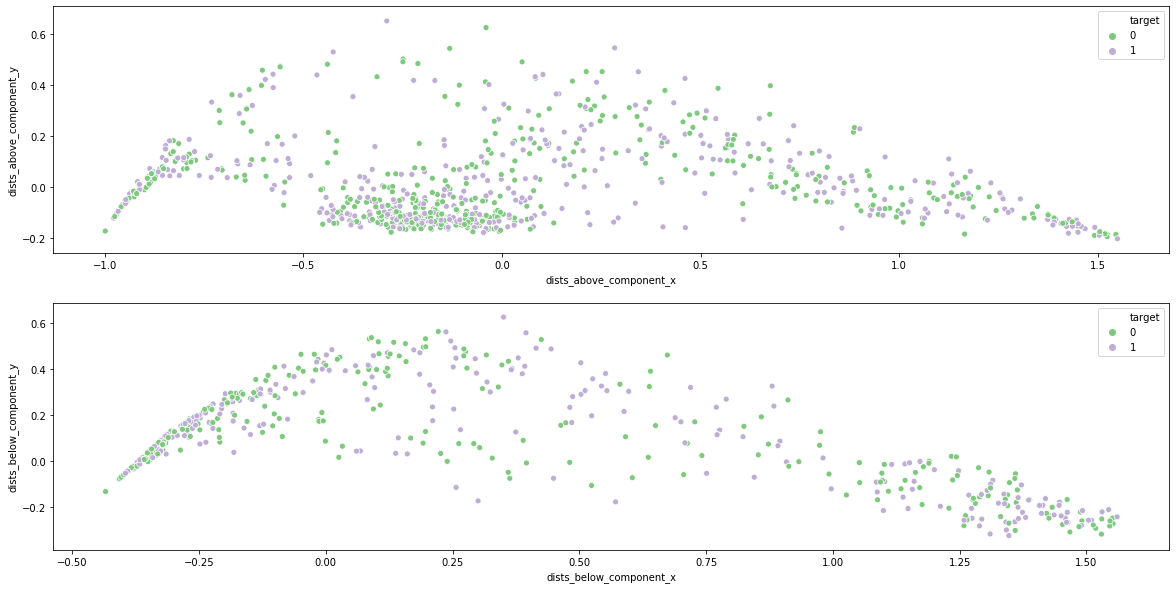

In [18]:
plot_components(original_data, 'dists', False, 20)
plt.show()

In [41]:
rows = []
for row in original_data.itertuples():
    dists = row.dists_below[0:20]
    dists += (row.dists_above[0:20])
    rows.append((dists + [row.num_peaks_below, row.num_peaks_above, row.avg_dist_below, row.avg_dist_above, row.technique, row.target]))

In [42]:
cols = ['dist_below' + str(x) for x in range(20)] + ['dist_above' + str(x) for x in range(20)] + ['num_peaks_below','num_peaks_above', 'avg_dist_below', 'avg_dist_above','technique', 'target']
training_data = pd.DataFrame(rows,columns=cols )
X = training_data.drop('target', axis=1)
y = training_data['target']

In [43]:
from model_trainer import ModelTrainer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
models = [RandomForestClassifier, LGBMClassifier, XGBClassifier]
names = ['rfc', 'lgbm', 'xgb']
mt = ModelTrainer(models, X, y, names)

In [44]:
accs, indices_preds = mt.kfold_models(5, model_params=[{'n_estimators': 10}, {}, {}])
accs

[0.6070548236294093, 0.6589278125189728, 0.6644648169510048]

### Get Results By with Dimension Reduced Data

In [45]:
from data_transformation import dimen_reduc_pca, dimen_reduc_tsne
above, below = dimen_reduc_tsne(original_data, 'dists', 20, 2)
rows = []
for i, row in enumerate(original_data.itertuples()):
    rows.append(list(above[i]) + list(below[i]) + [row.num_peaks_below, row.num_peaks_above, row.avg_dist_below, row.avg_dist_above, row.technique, row.target])

In [46]:
cols = ['dist_below' + str(x) for x in range(2)] + ['dist_above' + str(x) for x in range(2)] + ['num_peaks_below','num_peaks_above', 'avg_dist_below', 'avg_dist_above','technique', 'target']
training_data = pd.DataFrame(rows,columns=cols )
X = training_data.drop('target', axis=1)
y = training_data['target']

In [47]:
models = [RandomForestClassifier, LGBMClassifier, XGBClassifier]
names = ['rfc', 'lgbm', 'xgb']
mt = ModelTrainer(models, X, y, names)

In [48]:
accs, indices_preds = mt.kfold_models(5, model_params=[{'n_estimators': 100}, {}, {}])
accs

[0.6335316617084572, 0.6544714953554733, 0.6533665229797827]

### Get Results By Adding / Subtracting Error

In [49]:
from data_transformation import augment_spectra
add_offset = augment_spectra(original_data, 'offset', 1, 1, 0.05)
sub_offset = augment_spectra(original_data, 'offset', -1, 1, 0.05)

In [55]:
err_data = original_data.copy()
err_data['add_offset'] = add_offset
err_data['add_offset'] = err_data['add_offset'].apply(get_below_mass, args=(150,))
err_data['sub_offset'] = sub_offset
err_data['sub_offset'] = err_data['sub_offset'].apply(get_below_mass, args=(150,))
err_data = get_peak_data(err_data, nom_masses_low, nom_masses_high, num=20, threshold=0.1, masses='add_offset', prefix='add_offset_')
err_data = get_peak_data(err_data, nom_masses_low, nom_masses_high, num=20, threshold=0.1, masses='sub_offset', prefix='sub_offset_')

In [56]:
add_above, add_below = dimen_reduc_tsne(err_data, 'add_offset_dists', 15, 2)
sub_above, sub_below = dimen_reduc_tsne(err_data, 'sub_offset_dists', 15, 2)
above, below = dimen_reduc_tsne(err_data, 'dists', 15, 2)
rows = []
for i, row in enumerate(err_data.itertuples()):
    rows.append(list(above[i]) + list(below[i]) + list(sub_above[i]) + 
                list(sub_below[i]) + list(add_above[i]) + list(add_below[i])+ 
                [row.num_peaks_below, row.num_peaks_above, row.avg_dist_below,
                 row.avg_dist_above, row.add_offset_num_peaks_below, row.add_offset_num_peaks_above,
                 row.add_offset_avg_dist_below, row.add_offset_avg_dist_above,
                 row.sub_offset_num_peaks_below, row.sub_offset_num_peaks_above,
                 row.sub_offset_avg_dist_below, row.sub_offset_avg_dist_above,
                 row.technique, row.target])

In [57]:
training_data = pd.DataFrame(rows)
X = training_data.drop(len(training_data.columns) - 1, axis=1)
y = training_data[len(training_data.columns) - 1]

In [58]:
models = [RandomForestClassifier, LGBMClassifier, XGBClassifier]
names = ['rfc', 'lgbm', 'xgb']
mt = ModelTrainer(models, X, y, names)

In [59]:
accs, indices_preds = mt.kfold_models(5, model_params=[{'n_estimators': 100}, {}, {}])
accs

[0.6611863274846701, 0.6666929755327546, 0.6545807783376844]